In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

# Data Consolidation for Optimization Modeling

In [240]:
#Trip prediction data for 1/31/2019
path = "trips_final_20190301_20190331_v2.csv"
data = pd.read_csv(path)
data.head()

,Unnamed: 0,start_date,temperature,wind,precip_,station_id,station_cap,station_has_kiosk,trip_count_out,trip_count_in,...,station_cluster_7,station_cluster_8,start_dow_Friday,start_dow_Monday,start_dow_Saturday,start_dow_Sunday,start_dow_Thursday,start_dow_Tuesday,start_dow_Wednesday,trip_count_predicted
0,93988,2019-03-01 00:00:00+00:00,53.013773,0.999165,0.0,3,35,True,66.0,61.0,...,0,0,1,0,0,0,0,0,0,-4.0
1,93989,2019-03-01 00:00:00+00:00,53.013773,0.999165,0.0,4,35,True,13.0,17.0,...,0,0,1,0,0,0,0,0,0,4.0
2,93990,2019-03-01 00:00:00+00:00,53.013773,0.999165,0.0,5,35,True,50.0,53.0,...,0,0,1,0,0,0,0,0,0,10.0
3,93991,2019-03-01 00:00:00+00:00,53.013773,0.999165,0.0,6,23,True,48.0,37.0,...,0,0,1,0,0,0,0,0,0,-8.0
4,93992,2019-03-01 00:00:00+00:00,53.013773,0.999165,0.0,8,23,True,22.0,7.0,...,0,0,1,0,0,0,0,0,0,-13.0


In [241]:
#Net flow predicted for all stations on 03/31/2019
data_3_31_morning = data[(data['start_date'].str.match('2019-03-31')) & (data['start_period_morning']==1)]
bike_flow = data_3_31_morning['trip_count_predicted'].to_frame()
bike_flow.set_index(data_3_31_morning['station_id'], inplace=True)
bike_flow.columns = ['net']
bike_flow.head()

,net
station_id,
3,8.0
4,2.0
5,0.0
6,7.0
8,8.0


# Filter data to focus on most critically imbalanced stations

In [242]:
minflow, maxflow = -3, 3

I decided to focus on stations with a net bike flow outside of the range (-3,3) because those are the most unbalanced, and an LP solver will take far too long if it included every station. A plot below shows red dots, which will be the stations to focus on.

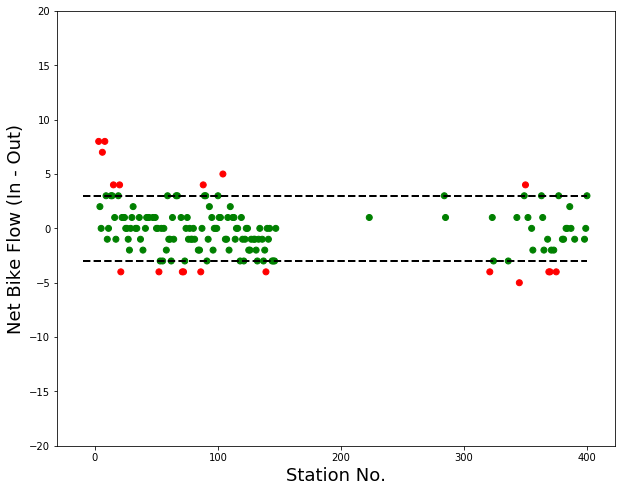

In [243]:
x = bike_flow.index
y = bike_flow['net'].values

plt.figure(figsize=(10,8))
plt.xlabel('Station No.', fontsize=18)
plt.ylabel('Net Bike Flow (In - Out)', fontsize=18)
plt.ylim(-20,20)
plt.plot([-10, 400], [maxflow, maxflow], color='k', linestyle='--', linewidth=2)
plt.plot([-10, 400], [minflow, minflow], color='k', linestyle='--', linewidth=2)
col = np.where(x<0,'k',np.where(np.logical_or(y>maxflow,y<minflow),'r','g'))
plt.scatter(x,y, color=col);

In [244]:
#Create source dataframe, with all stations that have large in-traffic
source_flow = bike_flow[bike_flow['net']>maxflow]
source_flow['net']

station_id
3      8.0
6      7.0
8      8.0
15     4.0
20     4.0
88     4.0
104    5.0
350    4.0
Name: net, dtype: float64

In [245]:
source_flow.shape[0]

8

In [246]:
#Create sink dataframe, with all stations that have large out-traffic
sink_flow = bike_flow[bike_flow['net']<minflow]
sink_flow['net']

station_id
21    -4.0
52    -4.0
71    -4.0
72    -4.0
86    -4.0
139   -4.0
321   -4.0
345   -5.0
369   -4.0
370   -4.0
375   -4.0
Name: net, dtype: float64

In [247]:
sink_flow.shape[0]

11

# Calculate Distances Between Relevant Stations

In [248]:
#Get locations of all stations (for distance calculation)
path2 = "trip_summary_201901.csv"
locations = pd.read_csv(path2)
cols = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
locations = locations[cols].drop_duplicates().set_index('start_station_id').sort_index()
locations.head()

,start_station_latitude,start_station_longitude
start_station_id,,
3,37.786375,-122.404904
4,37.785881,-122.408915
5,37.783899,-122.408445
6,37.804770,-122.403234
7,37.804562,-122.271738


In [249]:
#Function to calculate distance between two stations
def distance(station1id, station2id):
    a = locations.loc[station1id].values
    b = locations.loc[station2id].values
    return np.linalg.norm(a-b)

In [250]:
#Build a DataFrame of distances for all source-sink combinations
distances = pd.DataFrame(columns=['source','sink','distance'])
for i in source_flow.index:
    for j in sink_flow.index:
        distances = distances.append({'source': int(i), 'sink': int(j), 'distance': distance(i,j)}, ignore_index=True)
distances.head()

,source,sink,distance
0,3.0,21.0,0.005227
1,3.0,52.0,0.038004
2,3.0,71.0,0.036675
3,3.0,72.0,0.033770
4,3.0,86.0,0.027784


In [251]:
#Pivot data for more organized format
distances1 = distances.pivot(index='source',columns='sink',values='distance')
#distances.to_csv("distances.csv")
distances2 = pd.DataFrame(distances1)


# Python Optimization

In [252]:
distances['var_name'] = distances['source'].astype(str) + '_' + distances['sink'].astype(str)
distances.head()

,source,sink,distance,var_name
0,3.0,21.0,0.005227,3.0_21.0
1,3.0,52.0,0.038004,3.0_52.0
2,3.0,71.0,0.036675,3.0_71.0
3,3.0,72.0,0.033770,3.0_72.0
4,3.0,86.0,0.027784,3.0_86.0


In [253]:
sink_flow

,net
station_id,
21,-4.0
52,-4.0
71,-4.0
72,-4.0
86,-4.0
139,-4.0
321,-4.0
345,-5.0
369,-4.0


In [254]:
source_flow

,net
station_id,
3,8.0
6,7.0
8,8.0
15,4.0
20,4.0
88,4.0
104,5.0
350,4.0


In [255]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()


In [256]:
sources = set(distances['source'])
print(sources)

{3.0, 6.0, 8.0, 104.0, 15.0, 20.0, 88.0, 350.0}


In [257]:
sinks = set(distances['sink'])
print(sinks)

{321.0, 71.0, 72.0, 139.0, 369.0, 370.0, 52.0, 21.0, 86.0, 375.0, 345.0}


In [258]:
x = []
var_upper_bound = 10
var_lower_bound = 0
#w = []
#for source in sources:
#    x.append(model.NewIntVar(var_lower_bound, var_upper_bound, str(source)))
for i in range(len(distances)):
    
    x.append(model.NewIntVar(var_lower_bound, var_upper_bound, distances['var_name'][i]))
    #w.append(distances['distance'])
    #print("var_name = ",var_name)
    
w = [int(10000*y) for y in distances['distance']]

In [259]:
sourceflow = source_flow['net']
srcflow = [int(x) for x in sourceflow]
srcflow

[8, 7, 8, 4, 4, 4, 5, 4]

In [260]:
sinkflow = sink_flow['net']
snkflow = [int(x) for x in sinkflow]
snkflow

[-4, -4, -4, -4, -4, -4, -4, -5, -4, -4, -4]

In [261]:
model.Minimize(np.dot(x,w))

In [262]:
for k in range(len(sources)):
    j = len(sinks) * k
    z = int(3 - srcflow[k])
    zz = int(-3 - srcflow[k])
    
    model.Add(- sum([x[i] for i in range(j,j+len(sinks))])  -z <= 0) 
    model.Add(- sum([x[i] for i in range(j,j+len(sinks))]) -zz >= 0)



In [263]:
for k in range(len(sinks)):
    #print([[k+i*len(sinks)] for i in range(0, len(sources))])
    
    model.Add(sum([x[k+i*len(sinks)] for i in range(0, len(sources))]) + snkflow[k] <=3 ) 
    model.Add(sum([x[k+i*len(sinks)] for i in range(0, len(sources))]) + snkflow[k] >=-3 )



In [264]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
xx = []
if status == cp_model.OPTIMAL:
    print('Minimun of objective function: %i' % solver.ObjectiveValue())
    print()
    for i in range(len(distances)):
        
        #print('x value: ', solver.Value(x[i]))
        xx.append(solver.Value(x[i]))
arr = np.array(xx)
arr.shape = (len(sources), len(sinks))
new_df = pd.DataFrame(arr, index=source_flow.index.values)  
new_df.columns = sink_flow.index.values
new_df

Minimun of objective function: 3402



,21,52,71,72,86,139,321,345,369,370,375
3,0,0,0,0,0,0,5,0,0,0,0
6,0,1,0,0,0,0,0,0,1,1,1
8,5,0,0,0,0,0,0,0,0,0,0
15,1,0,0,0,0,0,0,0,0,0,0
20,1,0,0,0,0,0,0,0,0,0,0
88,0,0,1,1,1,0,0,0,0,0,0
104,0,0,0,0,0,0,0,2,0,0,0
350,0,0,0,0,0,1,0,0,0,0,0
